In [69]:
import torch
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from gurobipy import GRB, quicksum, Model

Given a linear programming problem:

minimize 
$$c'x$$

subject to 
$$Ax \geq b$$
$$x \geq 0$$

and a corresponding dual problem:

maximize 
$$b'y$$

subject to 
$$A'y \leq c$$
$$y \geq 0$$

Above, y is a dual variable

In the example below:

Summarizing the role of each variable:
* $x$ is the vector of primal variables to be optimized
* $c$ is the vector of coefficients for the objective function in the primal problem
* $d$ is a constant term in the objective function
* $G$ is the matrix of coefficients for the inequality constraints
* $h$ is the vector of constants on the right-hand size of the inequality constraints
* $A$ is the matrix of coefficients for the equality constraints
* $b$ is the vector of constants on the right-hand size of the equality constraints
* $\lambda$ is the vector of dual variables associated with the inequality constraints
* $v$ is the vector of dual variables associated with the equality constraints

In [2]:
# solving the primal problem
opt_mod = Model(name="cmu_simple_example")
c = np.array([2,1]).reshape(-1,1)
d = np.array([[3]])
G = np.array([[-3,0],[0,-4]])
h = np.array([-2,-5]).reshape(-1,1)
A = np.array([[1,1]])
b = np.array([[5]])

x = opt_mod.addMVar(shape=(2,1), name='x', lb=float('-inf'), ub=float('inf'))

# add the inequality constraints
ineq_c = opt_mod.addConstr(G@x <= h, name='c0')

# add the equality constraints
eq_c = opt_mod.addConstr(A@x == b, name='c1')

# set the objective function
obj_fn = c.T@x + d
opt_mod.setObjective(obj_fn, GRB.MINIMIZE)

opt_mod.optimize()

# output the result
print('Objective Function Value: %f' % opt_mod.ObjVal)
# Get values of the decision variables
for v in opt_mod.getVars():
    print('%s: %g' % (v.VarName, v.x))

ineq_pi = ineq_c.Pi
eq_pi = eq_c.Pi
print(f"Printing inequality constraint dual variables:\n {ineq_pi}")
print(f"Printing equality constraint dual variables:\n {eq_pi}")

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 3 rows, 2 columns and 4 nonzeros
Model fingerprint: 0x57f18b76
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 5e+00]
Presolve removed 3 rows and 2 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.6666667e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  8.666666667e+00
Objective Function Value: 8.666667
x[0,0]: 0.666667
x[1,0]: 4.33333
Printing inequality constraint dual variables:
 [[-0.33333333]
 [ 0.        

In [3]:
print(c.T@np.array([[2/3],[13/3]]) + d)
print(-h.T@np.array([[1/3],[0]]) - b.T@np.ones(1))

[[8.66666667]]
[[-4.33333333]]


In [4]:
# solving the dual problem
# solving the primal problem
opt_mod = Model(name="cmu_dual_example")

lambda_ = opt_mod.addMVar(shape=(2,1), name='lambda', lb=float('-inf'), ub=float('inf'))
v = opt_mod.addMVar(shape=(1,1), name='v', lb=float('-inf'), ub=float('inf'))

# add the inequality constraints
ineq_c = opt_mod.addConstr(lambda_ >= np.zeros(shape=(2,1)), name='c0')
# add the equality constraints
eq_c = opt_mod.addConstr(G.T@lambda_ + A.T@v + c == 0, name='c1')

# set the objective function
obj_fn = -h.T@lambda_ - b.T@v
opt_mod.setObjective(obj_fn, GRB.MAXIMIZE)

opt_mod.optimize()

# output the result
print('Objective Function Value: %f' % opt_mod.ObjVal)
# Get values of the decision variables
for v in opt_mod.getVars():
    print('%s: %g' % (v.VarName, v.x))

ineq_pi = ineq_c.Pi
eq_pi = eq_c.Pi
print(f"Printing inequality constraint dual variables:\n {ineq_pi}")
print(f"Printing equality constraint dual variables:\n {eq_pi}")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 4 rows, 3 columns and 6 nonzeros
Model fingerprint: 0xe0f81635
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [2e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 4 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.6666667e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  5.666666667e+00
Objective Function Value: 5.666667
lambda[0,0]: 0.333333
lambda[1,0]: 0
v[0,0]: -1
Printing inequality constraint dual variables:
 [[  0.        ]
 [-12.33333333]]
Printing equality constraint dual variables:
 [[-0

From the UC Berkley notes on the duality of linear programs, the following structure exhibits strong duality. 

**Primal LP** 

min $c'x$
$$Ax \geq b$$
$$x \geq 0 $$

**Dual LP**

max $y'b$
$$A'y \leq c$$
$$y \geq 0 $$

An example is shown below where
$$ c = \begin{bmatrix} 1 \\ 2 \\ \end{bmatrix}$$
$$ x = \begin{bmatrix} x_1 \\ x_2 \\ \end{bmatrix}$$
$$ y = \begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ y_4 \end{bmatrix}$$
$$ A = \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ 1 & 0 \\ 0 & 1 \\ \end{bmatrix}$$
$$ b = \begin{bmatrix} 1 \\ 1 \\ 1 \\ 1 \\ \end{bmatrix}$$

Notice the dual variables of the primal and dual match the solutions of the other. 

In [3]:
opt_mod = Model(name="simple_primal_example")
c = np.array([1,2]).reshape(-1,1)
A = np.vstack((np.eye(2), np.eye(2)))
b = np.array([1,1,0,0]).reshape(-1,1)
x = opt_mod.addMVar(shape=(2,1), name='x', lb=float('-inf'), ub=float('inf'))

# add the inequality constraints
ineq_c = opt_mod.addConstr(A@x >= b, name='c0')
ineq_c2 = opt_mod.addConstr(x >= 0, name='c1')

# set the objective function
obj_fn = c.T @ x
opt_mod.setObjective(obj_fn, GRB.MINIMIZE)

opt_mod.optimize()

# output the result
print('Objective Function Value: %f' % opt_mod.ObjVal)
# Get values of the decision variables
for v in opt_mod.getVars():
    print('%s: %g' % (v.VarName, v.x))

ineq_pi = ineq_c.Pi
print(f"Printing inequality constraint dual variables:\n {ineq_pi}")

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 6 rows, 2 columns and 6 nonzeros
Model fingerprint: 0x6a19e616
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6 rows and 2 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.000000000e+00
Objective Function Value: 3.000000
x[0,0]: 1
x[1,0]: 1
Printing inequality constraint dual variables:
 [[1.]
 [2.]
 [0.]
 [0.]]


In [4]:
opt_mod = Model(name="simple_dual_example")
y = opt_mod.addMVar(shape=(4,1), name='y', lb=float('-inf'), ub=float('inf'))
# add the inequality constraints
ineq_c = opt_mod.addConstr(A.T@y <= c, name='c0')
ineq_c2 = opt_mod.addConstr(y >= 0, name='c1')

# set the objective function
obj_fn = y.T @ b
opt_mod.setObjective(obj_fn, GRB.MAXIMIZE)

opt_mod.optimize()

# output the result
print('Objective Function Value: %f' % opt_mod.ObjVal)
# Get values of the decision variables
for v in opt_mod.getVars():
    print('%s: %g' % (v.VarName, v.x))

ineq_pi = ineq_c.Pi
print(f"Printing inequality constraint dual variables:\n {ineq_pi}")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 6 rows, 4 columns and 8 nonzeros
Model fingerprint: 0xb7fd577f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 6 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.000000000e+00
Objective Function Value: 3.000000
y[0,0]: 1
y[1,0]: 2
y[2,0]: 0
y[3,0]: 0
Printing inequality constraint dual variables:
 [[1.]
 [1.]]


The Lagrangian is $L(x,\lambda) = x_1 + 2x_2 + \lambda_1(-x_1 + 1) + \lambda_2(-x_2 + 1) + \lambda_3(-x_1) + \lambda_4(-x_2)$

In [10]:
# using Gurobi to maximize the Lagrangian using set variables of x
opt_mod = Model(name="simple_lagrange_example")
y = opt_mod.addMVar(shape=(4,1), name='y', lb=float('-inf'), ub=float('inf'))
x_close = np.array([[0.9999],[0.9999]])
# add the inequality constraints
ineq_c = opt_mod.addConstr(y >= 0, name='c0')
ineq_c2 = opt_mod.addConstr(y[0,0] + y[2,0] <= 1, name='c1')
ineq_c3 = opt_mod.addConstr(y[1,0] + y[3,0] <= 2, name='c2')

# set the objective function
obj_fn = c.T@x_close + y.T@(-A@x_close + b)
opt_mod.setObjective(obj_fn, GRB.MAXIMIZE)

opt_mod.optimize()

# output the result
print('Objective Function Value: %f' % opt_mod.ObjVal)
# Get values of the decision variables
for v in opt_mod.getVars():
    print('%s: %g' % (v.VarName, v.x))

ineq_pi = ineq_c.Pi
# ineq_pi2 = ineq_c2.Pi
# ineq_pi3 = ineq_c3.Pi
print(f"Printing inequality constraint dual variables:\n {ineq_pi}")#\n{ineq_pi2}\n{ineq_pi3}")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 6 rows, 4 columns and 8 nonzeros
Model fingerprint: 0x063611a6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 6 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.000000000e+00
Objective Function Value: 3.000000
y[0,0]: 1
y[1,0]: 2
y[2,0]: 0
y[3,0]: 0
Printing inequality constraint dual variables:
 [[ 0.]
 [ 0.]
 [-1.]
 [-1.]]


Initial lambda: tensor([[0.6320],
        [0.5819],
        [0.3931],
        [0.6109]])
Optimized lambda: tensor([[0.6320],
        [0.5819],
        [0.0000],
        [0.0000]])
Optimized x: tensor([[1.],
        [1.]])


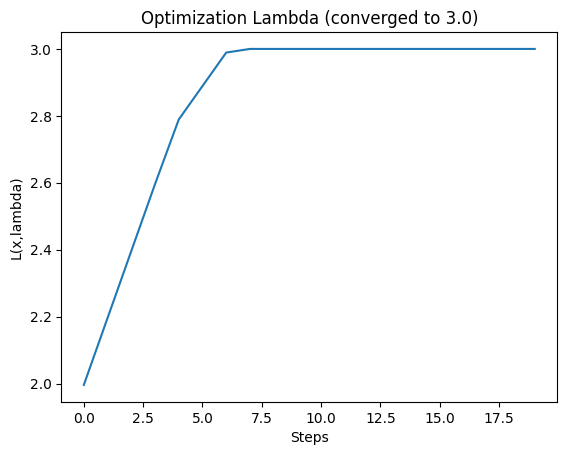

In [11]:
# x_close = torch.tensor([[0.9999],[0.9999]], requires_grad=False)
# x_close = torch.tensor([[1.0001],[0.9999]], requires_grad=False)
# x_close = torch.tensor([[0.9999],[1.0001]], requires_grad=False)
# x_close = torch.tensor([[1.0001],[1.0001]], requires_grad=False)
x_close = torch.tensor([[1.0],[1.0]], requires_grad=False)
lambda_ = torch.rand(4,1, requires_grad=True)

print(f"Initial lambda: {lambda_.data}")

A = np.vstack((np.eye(2), np.eye(2))).astype('float32')
b = np.array([1,1,0,0]).reshape(-1,1).astype('float32')
c = np.array([1,2]).reshape(-1,1).astype('float32')
A_t = torch.from_numpy(A)
b_t = torch.from_numpy(b)
c_t = torch.from_numpy(c)

def obj_fn(x, lambda_, A, b, c):
    return c.T@x + lambda_.T@(-A@x + b)

# Number of optimization steps
lr = 0.1
flip = True
flip_count = 40
num_steps = 20
# num_steps -= num_steps%flip_count


loss_graph = np.array([i for i in range(num_steps)])
loss_graph = np.vstack((loss_graph, np.zeros(num_steps)))

opt = torch.optim.Adam([lambda_], lr=lr, maximize=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.98)

# Optimization loop
for step in range(num_steps):

    y = obj_fn(x_close, lambda_, A_t, b_t, c_t)

    loss_graph[1, step] = y.item()

    opt.zero_grad(set_to_none=True)

    y.backward()

    opt.step()
    # scheduler.step()

    # clip lagrange values
    lambda_.data = torch.clip(lambda_.data, 0)

# The optimized values for x3 and x4
lambda_optimized = lambda_.data
x_optimized = x_close.data

print("Optimized lambda:", lambda_optimized)
print("Optimized x:", x_optimized)

fig = plt.figure()
plt.title(f"Optimization Lambda (converged to {loss_graph[1,-1]})")
plt.xlabel("Steps")
plt.ylabel("L(x,lambda)")
plt.plot(loss_graph[0,:], loss_graph[1,:])

In the example, we are trying to minimize the function $x_1 + x_2$ given the constraints $x_1 \leq 2$, $x_2 - 2 \leq 0$, and $-x_1 - x_2 + 2 \leq 0$. Notice that the output is convex, therefore there is a global minima and the solution is $x_1=x_2=1$. In the code below, $x$ and $\lambda$ are randomized and $x$ is minimized. Even with randomized, positive $\lambda$, the solution always converges to the global minimum. Afterwards, we maximize $\lambda$ and see that $\lambda_1=\lambda_2=0$. From this code, we cannot solve for dual variable $\lambda_3$ that solves the dual. Note that we cannot obtain the correct answer either using Gurobi as the object function is not a linear program. Also note that the solution to this dual problem is the solution to the primal, which is $x_1 + x_2 = 2, x_1=x_2=1$. 

Initial x: tensor([[0.6552],
        [0.7240]])
Initial lambda: tensor([[0.5322],
        [0.4142],
        [0.6875]])
Optimized x: tensor([[1.],
        [1.]])
Optimized lambda: tensor([[0.0000],
        [0.0000],
        [0.6875]])


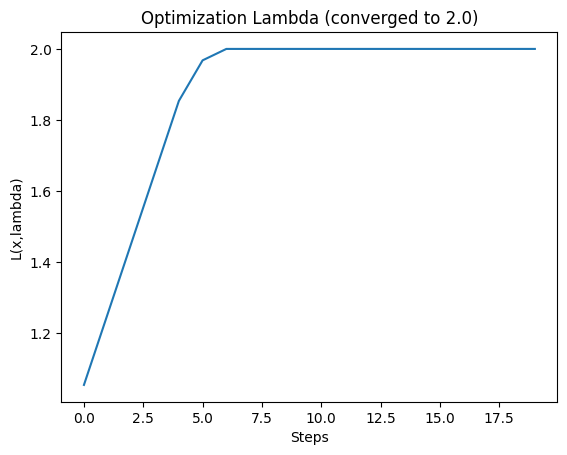

In [36]:
x = torch.rand(2,1, requires_grad=True)
lambda_ = torch.rand(3,1, requires_grad=True)

print(f"Initial x: {x.data}")
print(f"Initial lambda: {lambda_.data}")

A = np.array([[-1,0],[0,-1],[1,1]]).astype('float32')
b = np.array([-2,-2,2]).reshape(-1,1).astype('float32')
c = np.array([1,1]).reshape(-1,1).astype('float32')
A_t = torch.from_numpy(A)
b_t = torch.from_numpy(b)
c_t = torch.from_numpy(c)

def obj_fn(x, lambda_, A, b, c):
    return c.T@x + lambda_.T@(-A@x + b)

# Number of optimization steps
lr = 0.1
num_steps = 20

loss_graph = np.array([i for i in range(num_steps)])
loss_graph = np.vstack((loss_graph, np.zeros(num_steps)))

opt = torch.optim.Adam([x], lr=lr, maximize=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.98)

# Optimization loop
for step in range(num_steps):

    y = obj_fn(x_close, lambda_, A_t, b_t, c_t)

    loss_graph[1, step] = y.item()

    opt.zero_grad(set_to_none=True)

    y.backward()

    opt.step()
    scheduler.step()

    # clip lagrange values
    lambda_.data = torch.clip(lambda_.data, 0)

loss_graph = np.array([i for i in range(num_steps)])
loss_graph = np.vstack((loss_graph, np.zeros(num_steps)))

opt = torch.optim.Adam([lambda_], lr=lr, maximize=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.98)

# Optimization loop
for step in range(num_steps):

    y = obj_fn(x_close, lambda_, A_t, b_t, c_t)

    loss_graph[1, step] = y.item()

    opt.zero_grad(set_to_none=True)

    y.backward()

    opt.step()
    # scheduler.step()

    # clip lagrange values
    lambda_.data = torch.clip(lambda_.data, 0)

# The optimized values for x3 and x4
lambda_optimized = lambda_.data
x_optimized = x_close.data

print("Optimized x:", x_optimized)
print("Optimized lambda:", lambda_optimized)

fig = plt.figure()
plt.title(f"Optimization Lambda (converged to {loss_graph[1,-1]})")
plt.xlabel("Steps")
plt.ylabel("L(x,lambda)")
plt.plot(loss_graph[0,:], loss_graph[1,:])

This next example will work to minimze the function $x_3 = x_1^4-3x_1^3+2x_1^2+x_1+2+x_2^2$ which containts a global minimum and a local minimum. Since the function is nonconvex, the dual shall also be nonconvex depending on where $x$ and $\lambda$ is initialized as well as the constraints, there may be a duality gap. To start off, no constraints will be used and notice how depending on how $x$ is initialized, the minimum will converge to $(\frac{5-\sqrt{41}}{8}, 0,\frac{213-41\sqrt{41}}{512} + 2)$ or $(\frac{5+\sqrt{41}}{8}, 0, \frac{213+41\sqrt{41}}{512} + 2)$. Approximately these points translate numerically to $\approx(0.1754, 0,1.903)$, $\approx(1.4254, 0, 2.9288)$.

In [80]:
# Initialize figure with 4 3D subplots
fig = make_subplots(
    rows=1, cols=1,
    specs=[[{'type': 'surface'}]])

# Generate data
x = np.linspace(-0.2, 1.5, 100, dtype=np.float32)
y = np.linspace(-1.5, 1.5, 100, dtype=np.float32)
xGrid, yGrid = np.meshgrid(y, x)
z = xGrid**4 - 3*xGrid**3 + 2*xGrid**2 + xGrid + 2 + yGrid**2

# adding surfaces to subplots.
fig.add_trace(
    go.Surface(x=x, y=y, z=z, colorscale='Viridis', showscale=False),
    row=1, col=1)

fig.update_layout(
    title_text='3D subplots with different colorscales',
    height=800,
    width=800
)

fig.show()

Initial x1_1, x2_1: (-0.4484260678291321
Initial x1_2, x2_2: (2.0626907348632812
Optimized x1: -0.17454877495765686
Optimized x2: 0.0
Converged coordinate: (-0.175, 0.0, 1.903)
Optimized x1: 1.4308969974517822
Optimized x2: 0.0
Converged coordinate: (1.431, 0.0, 2.929)


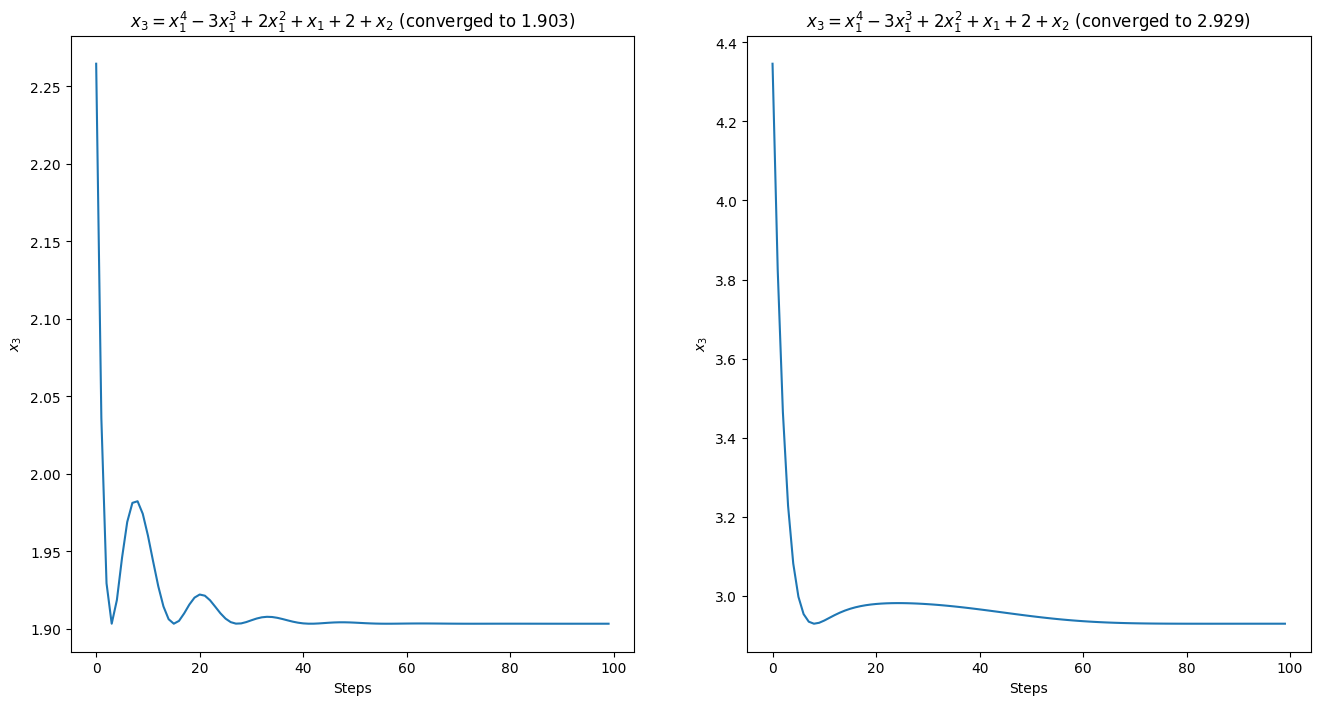

In [67]:
x1_1 = torch.rand(1) - 1.0
x1_1.requires_grad_(True)
x2_1 = torch.tensor(0.0, requires_grad=True)

x1_2 = torch.rand(1) + 2.0
x1_2.requires_grad_(True)
x2_2 = torch.tensor(0.0, requires_grad=True)
xs = [[x1_1, x2_1], [x1_2, x2_2]]

print(f"Initial x1_1, x2_1: ({x1_1.data.numpy()[0]}")
print(f"Initial x1_2, x2_2: ({x1_2.data.numpy()[0]}")

def obj_fn(x1, x2):
    return x1**4-3*x1**3+2*x1**2+x1+2 + x2**2

# Number of optimization steps
lr = 0.1
num_steps = 100

fig = plt.figure(figsize=(16,8))

for i, x_set in enumerate(xs):

    x1, x2 = x_set

    init_x1 = x1.data.clone().numpy()[0]

    loss_graph = np.array([i for i in range(num_steps)])
    loss_graph = np.vstack((loss_graph, np.zeros(num_steps)))

    opt = torch.optim.Adam([x1,x2], lr=lr, maximize=False)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.98)

    # Optimization loop
    for step in range(num_steps):

        y = obj_fn(x1, x2)

        loss_graph[1, step] = y.item()

        opt.zero_grad(set_to_none=True)

        y.backward()

        opt.step()
        scheduler.step()

    x1_optimized = x1.item()
    x2_optimized = x2.item()
    print("Optimized x1:", x1_optimized)
    print("Optimized x2:", x2_optimized)
    print(f"Converged coordinate: ({x1_optimized:1.3f}, {x2_optimized}, {loss_graph[1,-1]:1.3f})")

    plt.subplot(1,2,i+1)
    plt.title(f"$x_3 = x_1^4-3x_1^3+2x_1^2+x_1+2 + x_2$ (converged to {loss_graph[1,-1]:1.3f})")
    plt.xlabel("Steps")
    plt.ylabel("$x_3$")
    plt.plot(loss_graph[0,:], loss_graph[1,:])

Again, notice above how the value of convergence is dependent on how $x_1$ is initailized. Now, we will add the plane constraint $y \geq 2 \leftrightarrow -y + 2 \leq 0$

The solution should be:
$$x_1 = \frac{5-\sqrt{41}}{8}\approx0.1754$$
$$x_2 = 0.2$$
$$\lambda_1 = 0.4$$
The global minimum with this constraint is $x_3 \approx 1.943$ and the local minimum with this constraint is $x_3 \approx 2.969$

Initial x1_1, x2_1, l1_1: (-0.11059224605560303, 0.0, 0.31712841987609863
Initial x1_2, x2_2, l1_2: (2.972036600112915, 0.0, 0.624873697757721
Optimized x1: -0.16996924579143524
Optimized x2: 0.1690194308757782
Not optimized l1: 0.31712841987609863
First converged coordinate: (-0.170, 0.1690194308757782, 1.942) with $\lambda_1$=0.317

Optimized x1: -0.16996924579143524
Optimized x2: 0.1690194308757782
Optimized l1: 3.088625192642212
Second converged coordinate: (-0.170, 0.1690194308757782, 2.026) with $\lambda_1$=3.089


Optimized x1: 1.436505913734436
Optimized x2: 0.30747929215431213
Not optimized l1: 0.624873697757721
First converged coordinate: (1.437, 0.30747929215431213, 2.956) with $\lambda_1$=0.625

Optimized x1: 1.436505913734436
Optimized x2: 0.30747929215431213
Optimized l1: 0.0
Second converged coordinate: (1.437, 0.30747929215431213, 3.023) with $\lambda_1$=0.000




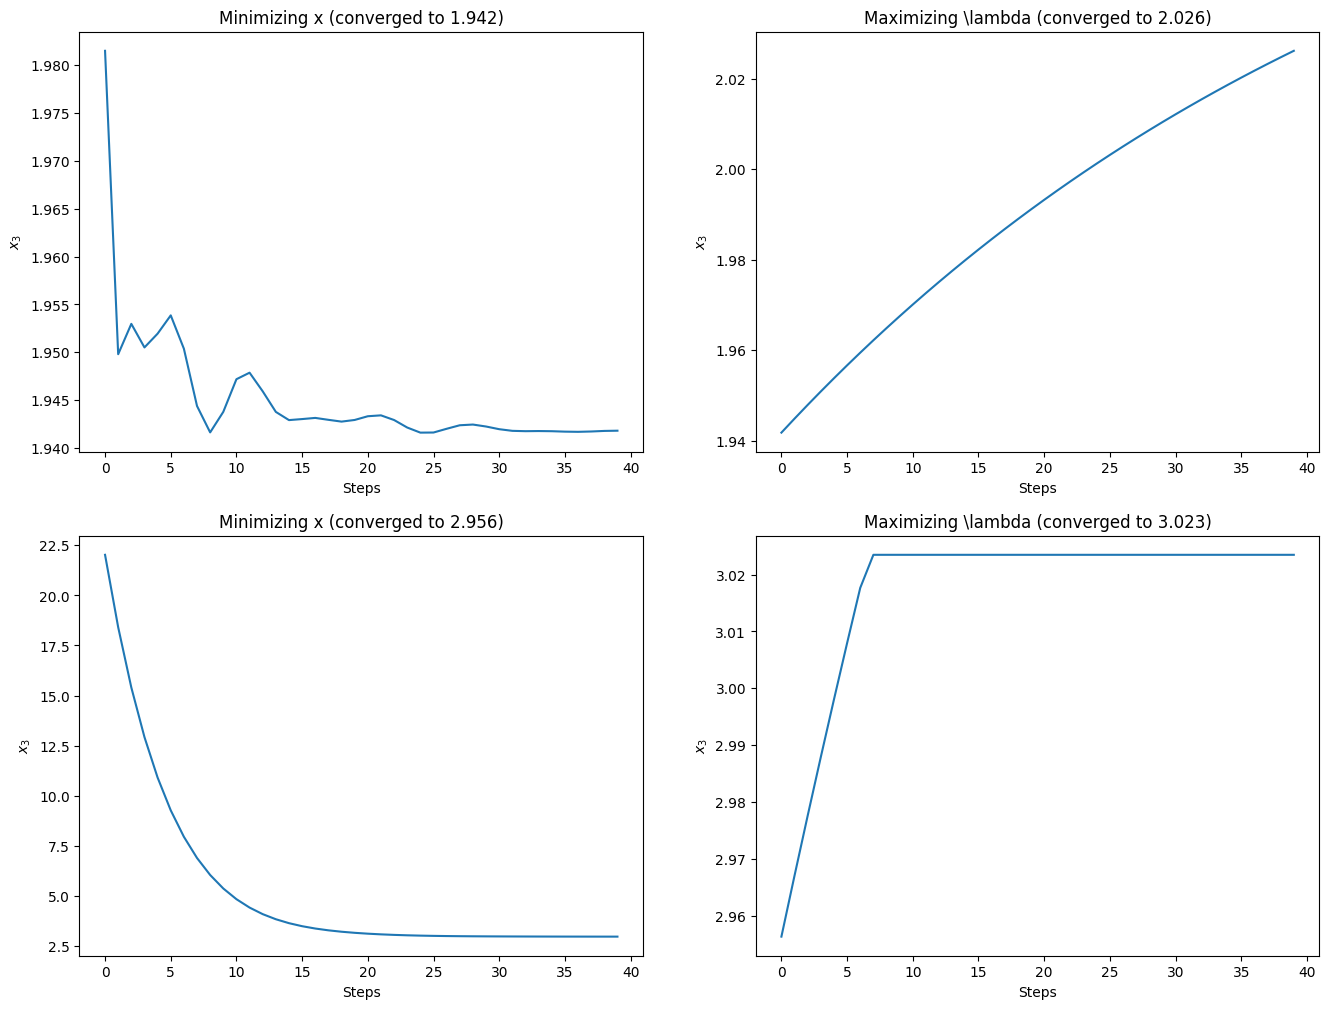

In [98]:
x1_1 = torch.rand(1) - 1.0
x1_1.requires_grad_(True)
x2_1 = torch.tensor(0.0, requires_grad=True)
l1_1 = torch.rand(1, requires_grad=False)

x1_2 = torch.rand(1) + 2.0
x1_2.requires_grad_(True)
x2_2 = torch.tensor(0.0, requires_grad=True)
l1_2 = torch.rand(1, requires_grad=False)

xs = [[x1_1, x2_1, l1_1], [x1_2, x2_2, l1_2]]

print(f"Initial x1_1, x2_1, l1_1: ({x1_1.data.numpy()[0]}, 0.0, {l1_1.data.numpy()[0]}")
print(f"Initial x1_2, x2_2, l1_2: ({x1_2.data.numpy()[0]}, 0.0, {l1_2.data.numpy()[0]}")

def obj_fn(x1, x2, l1):
    return x1**4-3*x1**3+2*x1**2+x1+2 + x2**2 + l1*(-x2 + 0.2)

# Number of optimization steps
lr = 0.1
num_steps = 40

fig = plt.figure(figsize=(16,12))

for i, x_set in enumerate(xs):

    x1, x2, l1 = x_set

    init_x1 = x1.data.clone().numpy()[0]

    loss_graph = np.array([i for i in range(num_steps)])
    loss_graph = np.vstack((loss_graph, np.zeros(num_steps)))

    opt = torch.optim.Adam([x1,x2], lr=lr, maximize=False)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.98)

    # Optimization loop
    for step in range(num_steps):

        y = obj_fn(x1, x2, l1)

        loss_graph[1, step] = y.item()

        opt.zero_grad(set_to_none=True)

        y.backward()

        opt.step()
        scheduler.step()

        # clip lagrange values
        l1.data = torch.clip(l1.data, 0)

    x1_optimized = x1.item()
    x2_optimized = x2.item()
    l1_optimized = l1.item()
    print("Optimized x1:", x1_optimized)
    print("Optimized x2:", x2_optimized)
    print("Not optimized l1:", l1_optimized)
    print(f"First converged coordinate: ({x1_optimized:1.3f}, {x2_optimized}, {loss_graph[1,-1]:1.3f}) with $\lambda_1$={l1_optimized:2.3f}\n")

    plt.subplot(2, 2,2*i+1)
    plt.title(f"Minimizing x (converged to {loss_graph[1,-1]:1.3f})")
    plt.xlabel("Steps")
    plt.ylabel("$x_3$")
    plt.plot(loss_graph[0,:], loss_graph[1,:])

    x1.requires_grad_(False)
    x2.requires_grad_(False)
    l1.requires_grad_(True)

    loss_graph = np.array([i for i in range(num_steps)])
    loss_graph = np.vstack((loss_graph, np.zeros(num_steps)))

    opt = torch.optim.Adam([l1], lr=lr, maximize=True)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.98)

    # Optimization loop
    for step in range(num_steps):

        y = obj_fn(x1, x2, l1)

        loss_graph[1, step] = y.item()

        opt.zero_grad(set_to_none=True)

        y.backward()

        opt.step()
        scheduler.step()

        # clip lagrange values
        l1.data = torch.clip(l1.data, 0)

    x1_optimized = x1.item()
    x2_optimized = x2.item()
    l1_optimized = l1.item()
    print("Optimized x1:", x1_optimized)
    print("Optimized x2:", x2_optimized)
    print("Optimized l1:", l1_optimized)
    print(f"Second converged coordinate: ({x1_optimized:1.3f}, {x2_optimized}, {loss_graph[1,-1]:1.3f}) with $\lambda_1$={l1_optimized:2.3f}\n\n")

    plt.subplot(2,2,2*i+2)
    plt.title(f"Maximizing \lambda (converged to {loss_graph[1,-1]:1.3f})")
    plt.xlabel("Steps")
    plt.ylabel("$x_3$")
    plt.plot(loss_graph[0,:], loss_graph[1,:])